# pytorch autoencoder build - 07/01/2021 

This is the big part of the project!! the autoencoder model will be built here and validated. need to first find all the modules i will need to use pytorch.

will need to learnn pytorch as well. 


## 

In [2]:
import torch 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split 
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [3]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH = "./models/model1.pth"

In [4]:
def load_dataset(data_path):
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    
    
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## 09/01/2021 - Learning Pytorch and how to implement a neural network in pytorch 

Pytorch is different to tensorflow. On this day I learn the basics of pytorch and how to load data from the folder 

The device data loader loads the data but also moves them to the gpu for faster computation. 

need to first load the training dataset into variables x, y, then load the datasets test datasets to test_dl, 

define the nvidia gpu as the device to use 


In [5]:
print(testset[0][0].shape)
print(type(dataset[0][0]))

torch.Size([1, 128, 16])
<class 'torch.Tensor'>


## 14/01/2021

Learnt how build simple networks in pytorch. However, need to learn how to define modeules ourselves, so that we can change the model architecture as we wish. Also, later on for the NP based neural network we are required to train the differnt parts of the system in different stages. this requires the networks to be separate.

The way to do this in pytorch is to use the nn.Module base class. 

Make a derived class from this base class to inherit all the things we need. 

The nn.Module will also require us to define the forward method, and provides the things needed to compute gradients by back propagation. 

The init method will define all the different layers that are used. first call super.__init__ to get the base class to initialise, then define all the different layers. 

In this Deep convolutional autoencoder build, will require some convolutional layers.

Use Leakyrelu as the activation function. can also use others. 

Flatten is required to convert all the feature images into a linear network in the middle. 

Would like to have a latent size which can be modified for model optimisation purposes.

Fully connected layer is also needed to bring the bottleneck layer dimension down to the number of latent variables we want. 

deconvolution layers are also required for the decoding network. 

For this, just put the encoding network together with the decoding network, shouldn't matter. 

In [6]:
latent_size = 10 
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)
        self.fc = nn.Linear(latent_size,4096)
        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out
autoencoder = Autoencoder()
autoencoder.to(device)
autoencoder.load_state_dict(torch.load(SAVED_MODEL_PATH))

<All keys matched successfully>

## 17/01/2021

the network should be put onto the gpu to stay consistent with the other parts. 

Without putting the network on the gpu there will be an error 

want to visualise the network. 

Can use the torchsammary module for this. 

Was difficult to get this working as the input size must be in this particular format. (1,128,16) else it won't go through. 

What this is doing is essentially running a minibatch with a size of 1 through the network. 

Good way to check if everything works. 

## 18/01/2021 

Something was broken in the network, can't seem to figure out. 

Keeps on giving an error about sizes being mismatched.

## 22/01/2021

Turns out that need to specify the shapes better in the linear and flatten layers in the middle. Pytorch won't calculate the number of neurons which should be in the middle layer automatically for you. 


In [7]:
from torchsummary import summary 
summary(autoencoder, input_size = (1,128,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                   [-1, 10]          40,970
         LeakyReLU-9                   [-1, 10]               0
           Linear-10                 [-1, 4096]          45,056
        LeakyReLU-11                 [-1, 4096]               0
  ConvTranspose2d-12            [-1, 64, 32, 4]          73,792
        LeakyReLU-13            [-1, 64, 32, 4]               0
  ConvTranspose2d-14            [-1, 32

## 25/01/2021

Checked with the guys at railway signals china, where they said they could possibly have some data for a related task. if these data can be obtained, it can potentially be used for further model validation. 

At this stage, it is infeasible to keep considering the possibility of a supervised model. should just focus on the unsupervised models.



## 29/01/2021 

should check what the spectrograms look like currently. can take a single minibatch from the test dataloader and display the image. 

the image should look like a normal spectrogram with some stripes or spots. 


## 30/01/2021 

the matplotlib plot seems to be using different colormaps compared to the librosa plots. Will update later to the librosa plots so that things are more or less consistent for the purpose of writing the report. 

Need to detach the images when trying to visualise, took a while to figure out. 

Started doing a generative adversarial network to learn how to use pytorch. the network would take image samples of fruits and try to generate new fruit samples which are not seen elsewhere. 

difficult to get it to train properly. 

In [8]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out[0][0].detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img, aspect = 'auto')


spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


## 31/1/2021

Now start training and see what the resulting image would look like 

Need to determine the error criterion and the optimiser to use, also the learning rates 

for the criterion we can use MSE loss, this is a standard form of error function used for autoencoders. later on tho when variational autoencoders are used, potentially need to change to a different error criterion. 

the optimiser can be any gradient descent algorithm. 

Can try standard minibatch gradient descent, then some momentum based methods, try adam

for learning rates keep at the default for now.

had some results with the generative adversial network, used some gpus from google and trained the network faster. The network generated some images which look a little bit liek a fuit. 

In [9]:
criterion = nn.MSELoss()
ae_opt= torch.optim.Adam(autoencoder.parameters(), lr = 0.0002)


## 02/02/2021

ready to start training 

for the number of epochs need to experiment a bit. 

in the training loop we need a for loop which loops over all epochs. 

inside the loop for each epoch, it needs another loop which loops over every minibatch in the datasets. 


can train in increments of 100 and see how the loss looks. 

seems to converge quite quickly. 

In [10]:
loss_list = []
EPOCHS = 100
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_dl):
        reconstructed = autoencoder(images)
        loss = criterion(images, reconstructed)
        
        ae_opt.zero_grad()
        loss.backward()
        ae_opt.step()
    
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, loss.item()))

        


epoch [1/100], loss:70.0412
epoch [2/100], loss:53.3931
epoch [3/100], loss:36.9946
epoch [4/100], loss:30.5634
epoch [5/100], loss:29.8854
epoch [6/100], loss:30.1445
epoch [7/100], loss:29.1693
epoch [8/100], loss:28.2627
epoch [9/100], loss:27.9055
epoch [10/100], loss:27.5835
epoch [11/100], loss:26.9570
epoch [12/100], loss:26.7803
epoch [13/100], loss:26.4113
epoch [14/100], loss:27.0797
epoch [15/100], loss:26.8299
epoch [16/100], loss:26.3305
epoch [17/100], loss:26.2788
epoch [18/100], loss:25.9718
epoch [19/100], loss:26.2398
epoch [20/100], loss:26.0502
epoch [21/100], loss:26.3946
epoch [22/100], loss:25.8631
epoch [23/100], loss:26.3730
epoch [24/100], loss:26.3297
epoch [25/100], loss:26.5858
epoch [26/100], loss:26.3549
epoch [27/100], loss:26.1504
epoch [28/100], loss:26.0392
epoch [29/100], loss:26.2396
epoch [30/100], loss:26.0031
epoch [31/100], loss:25.5140
epoch [32/100], loss:25.7772
epoch [33/100], loss:26.0177
epoch [34/100], loss:25.8844
epoch [35/100], loss:25

## 02/02/2021 

Save the training results to a file so that they can be loaded into the model if training was to be resumed. 


## 05/04/2021 

Can plot the result from the reconstruction side by side with the original input for a comparison. can include this in the report



In [11]:
torch.save(autoencoder.state_dict(), SAVED_MODEL_PATH)

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


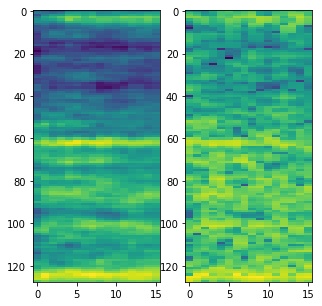

In [9]:

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (5,5))
axs[0].imshow(img, aspect = 'auto')
axs[1].imshow(images[1][0].detach().cpu(), aspect = 'auto')

## 05/02/2021

Would like to visualise the reconstruction error from the model. For this need to create a histogram of the reconstruciton errors. 

First step is to run through the entire test dataloader, for each image we would like to append its reconstruction loss into the list with the corresponding class.

Once the errors are put into the respective lists, the historgram can be plotted 

In [10]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    out = autoencoder(images)
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


## 05/02/2021 

The reconstruction error is plotted. The three categories of inputs formed three distinct peaks. This is good behaviour to see. 

They look like normal distributions, so fit some normal probability curve to it and see what it looks like. 

Dr Coombs suggested that I fix the axis titles and add in legends, also make things better named so that people can understand

Will do this in a later notebook when I optimise the model 

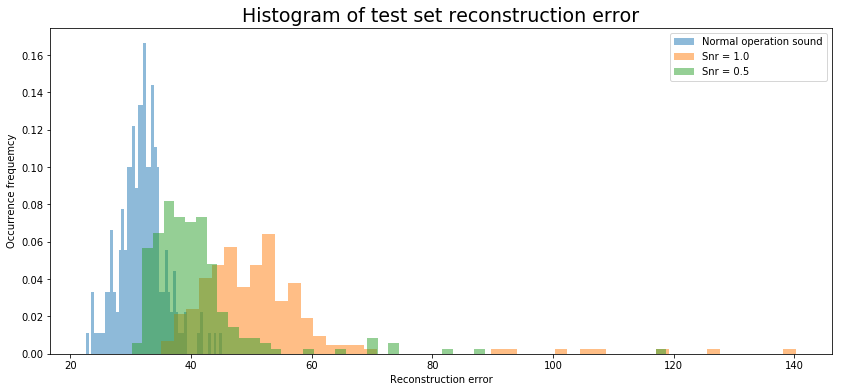

torch.Size([1, 128, 16])


In [11]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(len(out_list)):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


## 24/03/2021 

Following a discussion with Dr Coombs it was thought that we need to visualise the most confusing voids. 

The responses of voids with snr =1 was sorted 

the one with the min output was plotted using matplotlib. 

The spectrogram seems to very much resemble the normal operation sound spectrogram. 

This could be due to artefacts in the generation stage? 

This was generated to be not very obvious compared to most others. 

Shows that the model performance is fairly intuitive, what a human would struggle to identify is also difficult for the machine. Just by looking at the spectrogram, i would not say there is a void in the sample 


torch.Size([1, 128, 16])
torch.Size([128, 16])


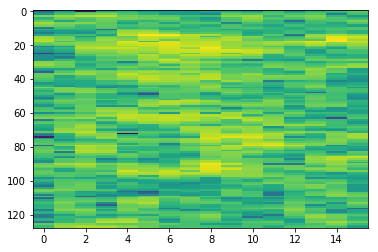

In [12]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

## 14/02/2021 

Need to fit a normal curve to the histograms.

Truncate the histograms so that the outliers with very extreme response are removed from the model. These will negatively affectthe model performance as it makes the variance very big. This suggests that the distribution is not quite that normal. Instead, simply remove the outliers and assume it is a normal distribution. This is the best way to get an accurate measure of the rate of mis-classification. 




## 25/02/2021 
The default font sizes are not suitable for this purpose. change the font sizes. 

The overlapping area between the distributions is the quantity we are actually interested in. The area betwen them should be shaded in order for it to appear nicely in the report. To calculate the area, numerical integration should be carried out. 

The area between the distributions is very small. This indicates very good model performance. 




The difference is 0.09010701890906976


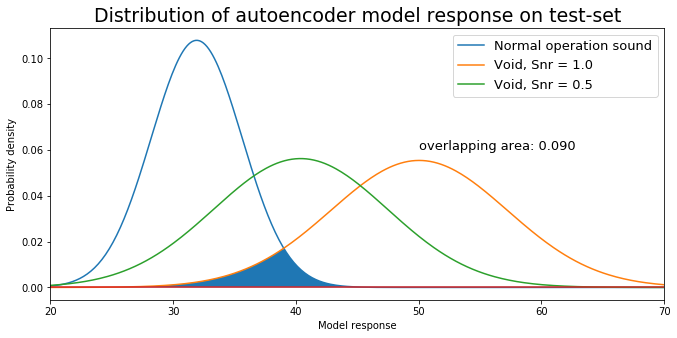

In [13]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


## 16/02/2021 

The receiver operating characteristic curve is a good indicator of model performance. the curve is produced by sweeping the detection threshold across a range of values, so that the false positive rate varies from 0 to 1. The true positive rate is calculated at the same time, and plotted on the curve. 

This can represent the trade off between the true positive and false positive rates, which is a problem with classifier design. We would like to have as high of a true positive rate as possible, without having a high false positive rate. 

The area under the roc curve is an important measure which directly indicates model performance.

a perfect classifier would have an area under the curve of 1. 

This theoretically perfect classifier would also pass  through the point (0,1) 


The aoc score is 0.993 for snr =1
The aoc score is 0.908 for snr =0.5


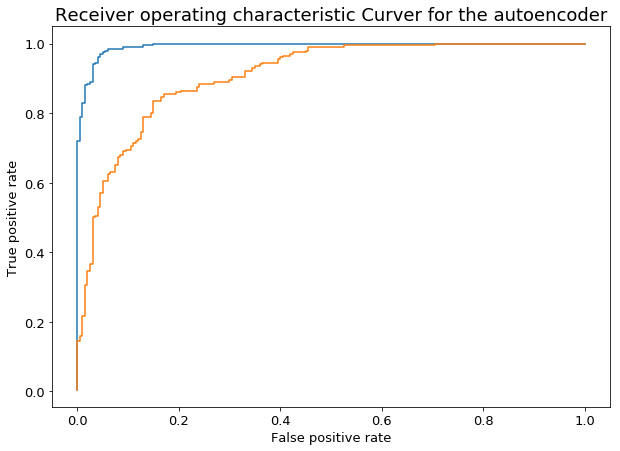

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle 
scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

with open("auto_roc.txt", "wb") as f: 
    pickle.dump({"fpr1":fpr1, "tpr1":tpr1, "thresholds1":thresholds1,"fpr2":fpr2, "tpr2":tpr2, "thresholds2":thresholds2
                , "scores1": scores1, "scores2": scores2, "y1": y1, "y2":y2},f)

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curver for the autoencoder")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1, tpr1)
ax.plot(fpr2, tpr2)

## 17/02/2021 discussion on the curve 

The graph has an aoc score of 0.993 for the case with higher SNR. This is very close to 1, meaning the model was able to perform very well. 

While keeping the false positive rate to a minimum of 0, the model was able to correctly classify 70% of all the true positive cases. 

This is very good performance. 

The cases with lower snr value has a much worse performance, with the aoc dropping to around 0.908. This, although still decent, is not very good if bayes rule is considered.

In fact if a conditional probability approach is taken for all snr settings, none of these performances seem that great, however, it would be far superior to what a human can do in any case. 




In [150]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    recons = autoencoder(xt)
    loss = mse_per_image(recons, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512
    


## 19/02/2021 

As before, would like to plot the response of the model on a spectrogram. This allows the model performance to be visualised. 

This is done by loading a piece of the back ground operation noise, which has a length of 10 seconds. 

The sound has 5 void samples in it, created through the synthetic data generation process. T

take slices with length of 0.35 seconds, then moving the window across the spectrogram. for each time step, calculate the anomaly score/ model response at that time step. 

plot the response on the spectrogram with twinx to overlay on top. 



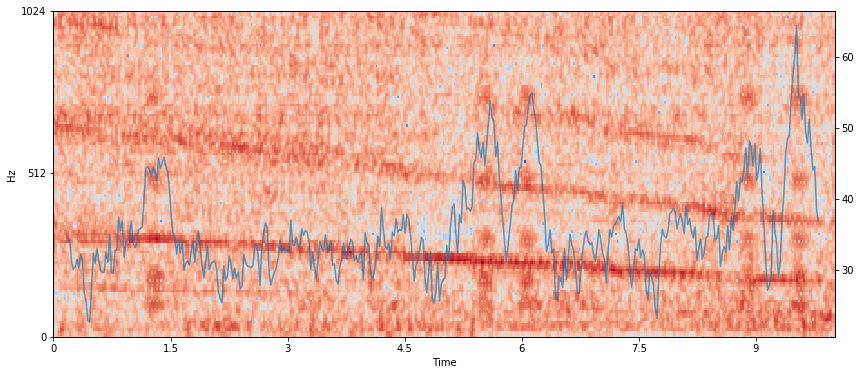

In [157]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.plot(x,score, alpha = 0.7)

## 19/02/2021 Discussion 

The response from the model seems to be very good, with fairly defined peaks at the locations of the voids. 




## 27/02/2021 

Following a discussion with Dr Coombs, would like to make a better representation of the network architecutre. THis was done through the use of the torchviz library. 

The resulting visualisation does not seem to be very useful, it is presented in a way which is relatively difficult for a non-machine learning oriented person to understand 

create the architecture plot manually. 

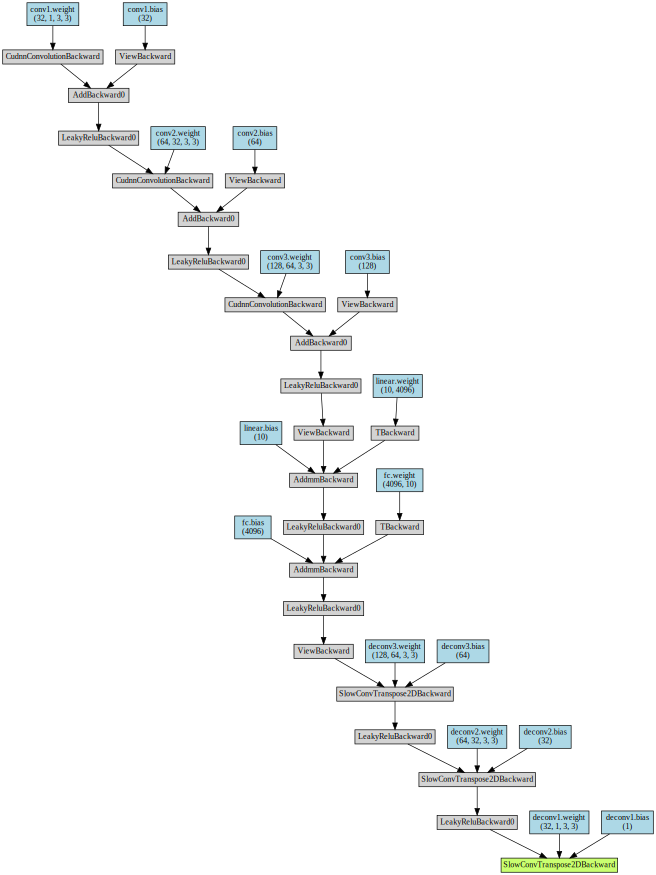

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)
